In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
%matplotlib inline

In [2]:
titer_file = '../data/titers_katzelnick2015/normalized_titers.csv'
patristic_distance_file = '../data/trees/tip_distances.csv'

colors = pickle.load(open('../figures/colors.p', 'rb'))
out_path = './png/'

In [3]:
patristic_distances = pd.read_csv(patristic_distance_file, index_col=None, header=None).to_dict(orient="records")
patristic_distances = {tuple(sorted([i[0], i[1]])): i[2] for i in patristic_distances}

In [4]:
titers = pd.read_csv(titer_file, sep=',', index_col=None)

In [7]:
distances = []
for idx,entry in titers.iterrows():
    strains = tuple(sorted([entry['virus'], entry['serum']]))
    if strains[0] == strains[1]:
        patristic = 0.
        homotypic = True
    else:
        try:
            patristic = patristic_distances[strains]
        except KeyError:
            continue
        homotypic = strains[0].split('/')[0] == strains[1].split('/')[0]
        
    distances.append({'strains': strains,
    'homotypic': homotypic,
    'patristic': patristic,
    'titer': entry['titer']})
distances = pd.DataFrame(distances)

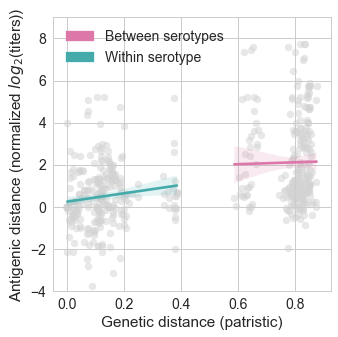

In [13]:
sns.set(style='whitegrid', font_scale=1.4)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(distances['patristic'].min()-.05, distances['patristic'].max()+.05)
ax.set_ylim(distances['titer'].min()-.05, distances['titer'].max()+.05)
homotypic = distances.loc[distances['homotypic'] == True]
heterotypic = distances.loc[distances['homotypic'] == False]

sns.regplot(x='patristic', y='titer', data=homotypic, 
            color=colors['all_effects'], ax=ax, scatter=False, truncate=True, n_boot=1000)
fit = linregress(homotypic['patristic'], homotypic['titer'])

sns.regplot(x='patristic', y='titer', data=heterotypic, 
            color=colors['interserotype_effects'], ax=ax, scatter=False, truncate=True, n_boot=1000)
fit = linregress(heterotypic['patristic'], heterotypic['titer'])
# sns.regplot(x='patristic', y='titer', data=distances, 
#            color='lightgray', ax=ax, scatter=False, truncate=True)

ax.scatter(distances['patristic'], distances['titer'], alpha=0.5, c='lightgray', zorder=0)

# ax.scatter(homotypic['patristic'], homotypic['titer'], alpha=0.4, c='lightgray', zorder=0)
# ax.scatter(heterotypic['patristic'], heterotypic['titer'], alpha=0.4, c='lightgray', zorder=0)

ax.set_xlabel('Genetic distance (patristic)')
ax.set_ylabel(r'Antigenic distance (normalized $log_2$(titers))')
interserotype_label = mpatches.Patch(color=colors['interserotype_effects'], label='Between serotypes')
intraserotype_label = mpatches.Patch(color=colors['all_effects'], label='Within serotype')

ax.set_ylim(-4,9)
plt.legend(handles=[interserotype_label, intraserotype_label])
plt.tight_layout()
plt.savefig('./png/genetic_antigenic_distance.png', dpi=300, bbox_inches='tight')

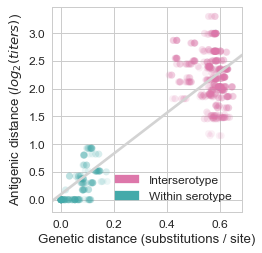

In [4]:
def plot_geno_pheno(df, ax):
    c = [ colors['all_effects'] if i==True else colors['interserotype_effects'] for i in df['homotypic'].values]
    sns.regplot('genetic', 'antigenic', data=df, 
                scatter_kws={'color': c, 'alpha': 0.1}, 
                line_kws={'color': 'lightgray'},
                ax=ax)
    ax.set_xlabel('Genetic distance (substitutions / site)')
    ax.set_ylabel('Antigenic distance ('+r'$log_2(titers)$'+')')

sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(7.5/2,7.5/2))

try:
    plot_geno_pheno(distances, ax)
except:
    print 'Oops. First calculate distances (see last cell)'
    
interserotype_label = mpatches.Patch(color=colors['interserotype_effects'], label='Interserotype')
intraserotype_label = mpatches.Patch(color=colors['all_effects'], label='Within serotype')
plt.legend(handles=[interserotype_label, intraserotype_label])

plt.tight_layout()
plt.savefig('./png/genetic_antigenic_distance.png', dpi=300, bbox_inches='tight')
plt.show()